In [1]:
import sys, os, platform, random, glob
from tabulate import tabulate

path = os.path.abspath('./aux/')
if path not in sys.path:
    sys.path.append(path)

import numpy as np
import pandas as pd
import nibabel as nib
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing, svm, metrics

from scipy.cluster import hierarchy

from aux import default_config as df_conf
from aux import func as sign
from aux import aux_fnc as ax

print('Python version: ', platform.python_version())
print('Numpy version: ', np.version.version)
print('Scipy version: ', scipy.__version__)
print('Matplotlib version: ', mpl.__version__)

Python version:  3.7.1
Numpy version:  1.15.4
Scipy version:  1.1.0
Matplotlib version:  3.0.2


In [2]:
labeled_file = './aux/labels.csv'
all_labels = pd.read_csv(labeled_file,sep=',')

group_opts = ['Freesurfer','Manual','Pardoe']
dirs_all = []
labels_all = []
for group_opt in group_opts:
    str_add = ''
    if group_opt == 'Freesurfer':
        str_add = 'T1_'

    list_opt = all_labels.loc[(all_labels['Label'] != -1) & (all_labels['Group'] == group_opt)]
    dirs_all += ['{}{}/{}{:06.0f}/'.format(df_conf.DIR_BAS,group_opt.lower(),str_add,cod) for cod in list_opt.Subject]
    labels_all += list(list_opt.Label)
#dirs_all, labels_all = dirs_all[:60], labels_all[:60]
print('Found dirs:',len(dirs_all))

Found dirs: 767


## Loading data

Segmentations' vector:  (767, 50, 500)


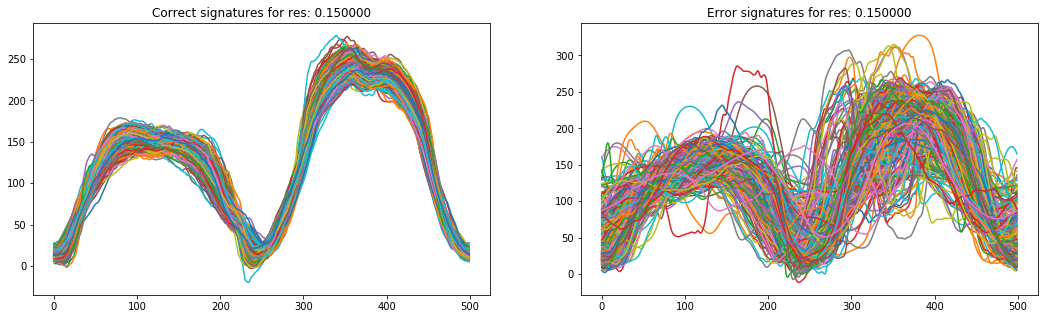

In [3]:
resols = np.arange(df_conf.RESOLS_INF,df_conf.RESOLS_SUP,df_conf.RESOLS_STEP)
resols = np.insert(resols,0,df_conf.FIT_RES)
prof_vec = np.empty((len(dirs_all),resols.shape[0],df_conf.POINTS))
reg_ex = np.round(0.3*df_conf.RESOLS_SUP/df_conf.RESOLS_STEP).astype('uint8')

for ind, mask_path in enumerate(dirs_all):
    pardoe_seg = glob.glob('{}*.corrected.cc.nii'.format(mask_path))
    if pardoe_seg != []:
        img_mask_msp = nib.load(pardoe_seg[0]).get_data()[::-1,::-1,0]
    else:
        file_mask_reg = '{}mask_reg'.format(mask_path)
        msp_points_reg = '{}msp_points_reg'.format(mask_path)

        in_img_msp = nib.load('{}.nii.gz'.format(msp_points_reg)).get_data()
        msp = np.argmax(np.sum(np.sum(in_img_msp,axis=-1),axis=-1))

        in_img_mask = nib.load('{}.nii.gz'.format(file_mask_reg)).get_data()
        img_mask_msp = in_img_mask[msp]

    refer_temp = sign.sign_extract(img_mask_msp, resols, df_conf.SMOOTHNESS, df_conf.POINTS)
    prof_vec[ind] = refer_temp

    if ind > 0: #Fitting curves using the first one as basis
        prof_ref = prof_vec[0]
        prof_vec[ind] = sign.sign_fit(prof_ref[0], refer_temp, df_conf.POINTS)

print("Segmentations' vector: ", prof_vec.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))

labels_True = np.array(labels_all)==0
labels_False = np.array(labels_all)==1

ax1.plot(prof_vec[labels_True,reg_ex].T)
ax1.set_title('Correct signatures for res: %f'%(resols[reg_ex]))
ax2.plot(prof_vec[labels_False,reg_ex].T)
ax2.set_title('Error signatures for res: %f'%(resols[reg_ex]))
plt.show()

In [4]:
Y_total = np.array(labels_all)
Y_filt = Y_total != 2 #Filtering labels {0:correct,1:error,2:soft_error}
Y_total = Y_total[Y_filt]
X_total = prof_vec[Y_filt,1:,:] #Filtering the fitting resolution
resols = resols[1:] #Filtering the fitting resolution
resols_ref = np.arange(1,len(resols)+1)

print("Arrays' size:",X_total.shape,Y_total.shape)
print('Dic labels count:',np.unique(Y_total, return_counts=True))
print('Initial division:', np.sum(Y_total)/len(Y_total))
split_train = split_valid = 0.35

sss = StratifiedShuffleSplit(n_splits=1, test_size=split_valid, train_size=split_train, random_state=13)#33
train_index, valid_index = next(sss.split(X_total, Y_total))
test_index = np.ones((len(Y_total))).astype('bool')
test_index[np.concatenate((train_index,valid_index))] = False
test_index = np.arange(len(Y_total))[test_index]
X_train = X_total[train_index]
X_valid = X_total[valid_index]
X_test = X_total[test_index]
Y_train = Y_total[train_index]
Y_valid = Y_total[valid_index]
Y_test = Y_total[test_index]

val_norm = np.amax(np.amax(X_train,axis=0),axis=-1).reshape(1,-1,1)
X_train_norm = X_train/val_norm
X_valid_norm = X_valid/val_norm
X_test_norm = X_test/val_norm

print('Train set: ({})'.format(split_train),X_train_norm.shape, Y_train.shape, np.sum(Y_train)/len(Y_train))
print('Valid set: ({})'.format(split_valid),X_valid_norm.shape, Y_valid.shape, np.sum(Y_valid)/len(Y_valid))
print('Test set: ({})'.format(1-(split_train+split_valid)), X_test_norm.shape,
      Y_test.shape,np.sum(Y_test)/len(Y_test))

Arrays' size: (688, 49, 500) (688,)
Dic labels count: (array([0, 1]), array([401, 287]))
Initial division: 0.4171511627906977
Train set: (0.35) (240, 49, 500) (240,) 0.4166666666666667
Valid set: (0.35) (241, 49, 500) (241,) 0.4190871369294606
Test set: (0.30000000000000004) (207, 49, 500) (207,) 0.41545893719806765


--------------------------------------------------------------------
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0.8565063649222064  at res:  0.01
--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0.9205445544554455  at res:  0.02
--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0.924

--------------------------------------------------------------------
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0.9078854314002829  at res:  0.25
--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0.9150282885431399  at res:  0.26
--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0

--------------------------------------------------------------------
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=44, shrinking=True,
  tol=0.001, verbose=False)
Final AUC:  0.9128359264497878  at res:  0.49


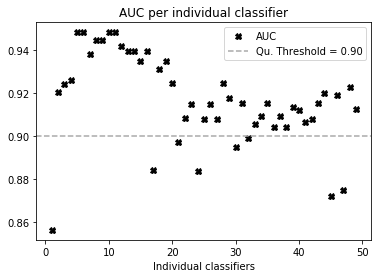

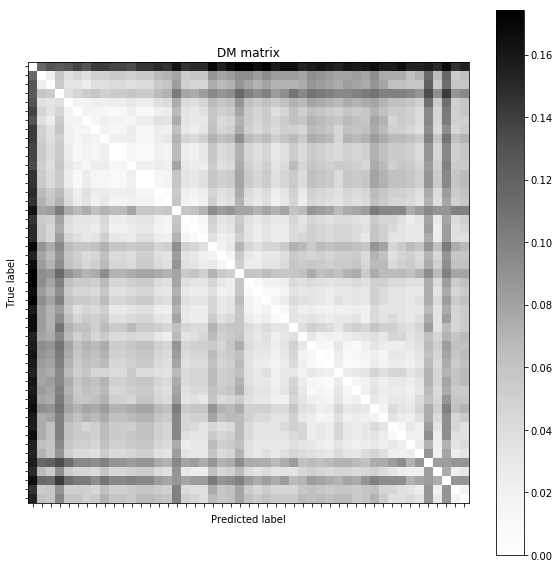

In [5]:
tuned_parameters = [{'kernel': ['rbf', 'poly', 'linear'], 
                     'C': [0.1, 1, 10, 20, 50, 100], 
                     'degree': [2, 3, 4]}]
cv_s = StratifiedKFold(5, shuffle=True, random_state=22)#2

acum_pred = np.array([]).reshape(0,Y_valid.shape[0])
d_train = {}
auc_vec = []

# Each resolution is used as feature shape alogn with one SVM classifier
# Select best hyperparameters for each resolution/classifier using CV
for res in np.arange(resols.shape[0]):
    d_train['string{0}'.format(res)] = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=44,#4
                                                            probability=True,),
                                                    tuned_parameters, iid=False, cv=cv_s, scoring='roc_auc')
    d_train['string{0}'.format(res)].fit(X_train_norm[:,res,:], Y_train)
    print('--------------------------------------------------------------------')
    print(d_train['string{0}'.format(res)].best_estimator_)

    y_pred = d_train['string{0}'.format(res)].predict(X_valid_norm[:,res,:])
    
    fpr, tpr, thresholds = metrics.roc_curve(Y_valid, y_pred)
    auc_vec.append(metrics.auc(fpr, tpr))
    print('Final AUC: ', auc_vec[-1], ' at res: ', resols[res])
    acum_pred = np.vstack((acum_pred, y_pred))

th_auc = 0.9
    
plt.figure()
plt.plot(np.arange(1,len(auc_vec)+1), auc_vec, 'X', color='black', label='AUC')
plt.axhline(y=th_auc, label='Qu. Threshold = {0:.2f}'.format(th_auc), c='darkgray', linestyle='--')
plt.title('AUC per individual classifier')
plt.xlabel('Individual classifiers')
plt.legend(loc='best')
plt.show()
    
acum_acc = np.logical_not(np.logical_xor(acum_pred.astype('bool'),Y_valid.astype('bool')))

mm_conf = np.empty((4,acum_acc.shape[0],acum_acc.shape[0]))
for i in range(acum_acc.shape[0]):
    for j in range(acum_acc.shape[0]):
        mm_conf[:,i,j] = ax.agreement_matrix(acum_acc[i],acum_acc[j])

a = mm_conf[0]
b = mm_conf[1]
c = mm_conf[2]
d = mm_conf[3]

#DM = (a*d-b*c)/(a*d+b*c)
#DM = (a+b+c)/(a+b+c+d)
DM = (b+c)/(a+b+c+d)

ax.plot_matrix(DM, classes=map(str, resols), cmap=plt.cm.Greys, title='DM matrix')

/home/wilomaku/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


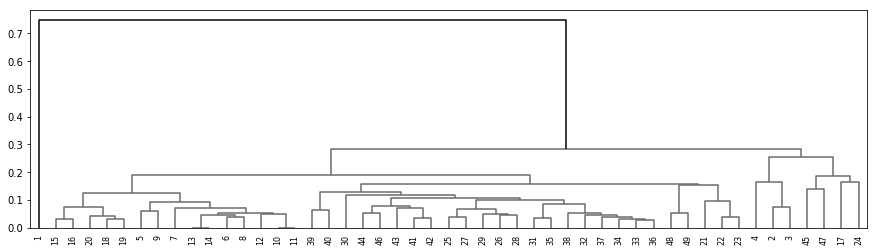

/home/wilomaku/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


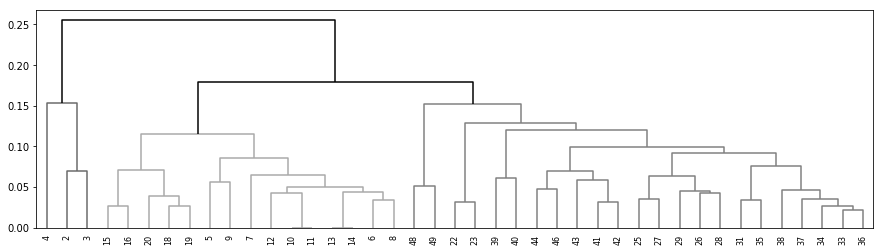

In [6]:
hierarchy.set_link_color_palette(['dimgrey', 'darkgray', 'gray', 'silver',])

Z = hierarchy.linkage(DM, 'average', optimal_ordering=False)
label_z = np.arange(1,len(DM)+1)

fig = plt.figure(figsize=(15, 4))
dend = hierarchy.dendrogram(Z, labels=label_z, above_threshold_color='black')
plt.show()

auc_vec_th = np.array(auc_vec) > th_auc
filt_acc = np.array(auc_vec)[auc_vec_th]

#Updating vectors
DM_th = DM[auc_vec_th][:,auc_vec_th]
resols_ref_th = resols_ref[auc_vec_th]
X_valid_norm_th = X_valid_norm[:,auc_vec_th,:]
X_test_norm_th = X_test_norm[:,auc_vec_th,:]

Z = hierarchy.linkage(DM_th, 'average', optimal_ordering=False)
fig = plt.figure(figsize=(15, 4))
dend = hierarchy.dendrogram(Z, labels=label_z[auc_vec_th], above_threshold_color='black')
plt.show()

hierarchy.set_link_color_palette(None)

Clusters: 1 Choosen resolutions: [5]
--------------------------------------------------------------------
SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 1  / Final AUC:  0.9011627906976745
Clusters: 2 Choosen resolutions: [5 4]
--------------------------------------------------------------------
SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 2  / Final AUC:  0.9011627906976745
Clusters: 3 Choosen resolutions: [ 5  4 28]
--------------------------------------------------------------------
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=

--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 21  / Final AUC:  0.9476744186046512
Clusters: 22 Choosen resolutions: [34 28  6 23 42 40 19 29 16 48 49  3  5 43 44  2  4 35 12 46 31 39]
--------------------------------------------------------------------
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 22  / Final AUC:  0.9476744186046512
Clusters: 23 Choosen resolutions: [ 6 28 34 23 42 40 19 29 16 48 49  3  5 43 44  2  4 35 12 46 31 39 38]
--------------------------------------------------------------------
SVC(C=50, cach

--------------------------------------------------------------------
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 38  / Final AUC:  0.9476744186046512
Clusters: 39 Choosen resolutions: [13 49 10 42 48 40 44 41 36 46 39 23 27 43 37 29 34 35 18 16 31 28 38  3
  9  5 25 22  7  8 20  2 26  4  6 19 33 12 15]
--------------------------------------------------------------------
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=16, shrinking=True,
  tol=0.001, verbose=False)
Number of clusters: 39  / Final AUC:  0.9476744186046512
Clusters: 40 Choosen resolutions: [10 49 44 42 48 40 43 41 36 46 39 23 27 22 37 29 34 35 18 16 31 28 38  3
  9  5 25 14  7  8 20  2 26

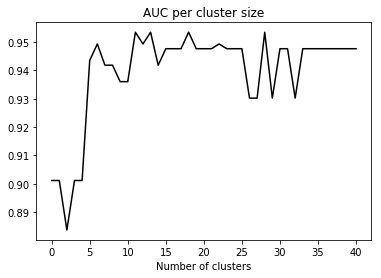

In [7]:
 tuned_parameters_ens = [{'kernel': ['rbf', 'poly', 'linear'], 
                          'C': [0.1, 1, 10, 20, 50, 100], 
                          'degree': [2, 3, 4]}]

cv_ens = StratifiedKFold(5, shuffle=True, random_state=88)#8
num_clusters = np.arange(1,len(DM_th)+1)
clusters_auc = []

# All the possible clusters ranging from 1 (grouping all 49 resolutions) to 49 (one cluster for resolution)
for n_cl in num_clusters:
    agg = AgglomerativeClustering(n_clusters=n_cl, affinity='precomputed', linkage='average')
    labels_res = agg.fit_predict(DM_th)

    list_clusters = []
    res_chs = []
    labels_list = np.unique(labels_res)
    for clust in labels_list:
        res_clust = np.where(labels_res==clust)[0]
        list_clusters.append(res_clust)
        #print "Set({}): ".format(clust), resols_ref_th[res_clust]
        if df_conf.CHOSEN_METHOD == 'random':
            res_chs.append(random.choice(res_clust))
        elif df_conf.CHOSEN_METHOD == 'min_dist':
            sum_dist = []
            for r_clust in res_clust:
                sum_dist.append(np.sum(DM_th[r_clust,res_clust]))
            res_chs.append(res_clust[np.argmin(sum_dist)])
        elif df_conf.CHOSEN_METHOD == 'best_acc':
            clust_acc = filt_acc.copy()
            clust_acc[np.where(labels_res!=clust)[0]] = 0
            res_chs.append(np.argmax(clust_acc))
        else:
            raise Exception('Bad option')
    print("Clusters:", len(list_clusters), "Choosen resolutions:", resols_ref_th[res_chs])

    svm_ind = np.array([]).reshape(0,Y_valid.shape[0])
    for res_ch in res_chs:
        svm_ind = np.vstack((svm_ind, 
                             d_train['string{0}'.format(res_ch)].predict_proba(X_valid_norm_th[:,res_ch,:])[:,1]))
    svm_ind = svm_ind.T
    clf = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=16), tuned_parameters_ens, 
                       iid=False, cv=cv_ens, scoring='roc_auc')
    clf.fit(svm_ind, Y_valid)
    svm_ind = np.array([]).reshape(0,Y_test.shape[0])
    for res_ch in res_chs:
        svm_ind = np.vstack((svm_ind, 
                             d_train['string{0}'.format(res_ch)].predict_proba(X_test_norm_th[:,res_ch,:])[:,1]))
    svm_ind = svm_ind.T
    y_pred = clf.predict(svm_ind)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred)
    AUC_cl = metrics.auc(fpr, tpr)
    print('--------------------------------------------------------------------')
    print(clf.best_estimator_)
    print('Number of clusters:', n_cl, ' / Final AUC: ', AUC_cl)
    clusters_auc.append(AUC_cl)

plt.figure()
plt.plot(clusters_auc, color='black')
plt.title('AUC per cluster size')
plt.xlabel('Number of clusters')
plt.show()

In [8]:
max_auc, min_auc = np.amax(clusters_auc), np.amin(clusters_auc)
pc_best_auc_exp = 0.99
num_clust_ch = np.where(clusters_auc > min_auc+pc_best_auc_exp*(max_auc-min_auc))[0][0]+1
print('Best cluster size: {} (with at least {} of best result)'.format(num_clust_ch,pc_best_auc_exp))

agg = AgglomerativeClustering(n_clusters=num_clust_ch, affinity='precomputed', linkage='average')
labels_res = agg.fit_predict(DM_th)
print('Element labels', labels_res)

list_clusters = []
res_chs = []
labels_list = np.unique(labels_res)
for clust in labels_list:
    res_clust = np.where(labels_res==clust)[0]
    list_clusters.append(res_clust)
    print("--------------------------------------------------------------------")
    if len(res_clust) == 1:
        dist_intra = np.amax(DM_th[res_clust[0],res_clust[0]])
    else:
        dist_intra = np.amax(DM_th[res_clust[0],res_clust[1:]])
    print('Cluster({}): '.format(clust),resols_ref_th[res_clust],'Distance intra: ',dist_intra)

    for res_ch in res_clust:
        y_pred = d_train['string{0}'.format(res_ch)].predict(X_test_norm_th[:,res_ch,:])
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred)
        AUC_cl = metrics.auc(fpr, tpr)

        ind_err_rand = np.where(np.logical_xor(Y_test, y_pred))
        ind_err = test_index[ind_err_rand]
        print('Element({}): '.format(resols_ref_th[res_ch]),ind_err, 'AUC:({})'.format(AUC_cl))

    if df_conf.CHOSEN_METHOD == 'random':
        res_chs.append(random.choice(res_clust))
    elif df_conf.CHOSEN_METHOD == 'min_dist':
        sum_dist = []
        for r_clust in res_clust:
            sum_dist.append(np.sum(DM_th[r_clust,res_clust]))
        res_chs.append(res_clust[np.argmin(sum_dist)])
    elif df_conf.CHOSEN_METHOD == 'best_acc':
        clust_acc = filt_acc.copy()
        clust_acc[np.where(labels_res!=clust)[0]] = 0
        res_chs.append(np.argmax(clust_acc))
    else:
        raise Exception('Bad option')

Best cluster size: 12 (with at least 0.99 of best result)
Element labels [ 4  4  7  0  0  0  0  0  0  0  0  0  0  9  9  9  9  9  8  8  5  5  5  5
  5  3 11 11  3 11 11 11 10 10  1  1  2  1  2  6  6]
--------------------------------------------------------------------
Cluster(0):  [ 5  6  7  8  9 10 11 12 13 14] Distance intra:  0.029045643153526972
Element(5):  [ 24  25  51  65 110 114 127 130 134 136 139 157 169 180 186 187 191 219
 241 245 263 266 272] AUC:(0.8662790697674418)
Element(6):  [ 24  25  51  65  94 110 114 127 133 134 139 157 162 169 180 186 187 191
 219 241 245 263 266 272] AUC:(0.8604651162790697)
Element(7):  [ 24  25  51  65  94 110 114 139 157 162 169 180 186 187 191 241 245 263
 266 272] AUC:(0.8837209302325582)
Element(8):  [ 24  25  51  65  94 110 114 130 139 157 162 169 180 186 187 191 241 245
 263 272] AUC:(0.8837209302325582)
Element(9):  [ 25  65  94 110 114 139 157 162 169 180 186 187 241 245 263 272] AUC:(0.9069767441860466)
Element(10):  [ 24  25  51  65  9

Element(20):  [ 15  65  94 110 114 139 157 162 186 219 241 245 263 272 308] AUC:(0.9127906976744187)
--------------------------------------------------------------------
Cluster(10):  [39 40] Distance intra:  0.016597510373443983
Element(39):  [  2  20  45  74 172 190 285 294 295 296 302 320 321 322 323 330 331 333
 349 350 352 357 361 364 365 367 371 381 382 383 393 395 404 406 407 410
 415 417 423 424 425 427 431 433 434 436 440 443 447 451 453 460 463 465
 466 467 476 477 482 489 491 495 500 504 509 516 517 519 523 526 530 531
 534 537 540 542 543 545 547 548 549 563 565 567 568 570 572 577 578 583
 584 590 592 595 596 601 602 604 613 614 615 616 618 619 624 625 629 631
 637 639 640 641 650 664 666 678 681 683 684 685 686] AUC:(0.5)
Element(40):  [  2  20  45  74 172 190 285 294 295 296 302 320 321 322 323 330 331 333
 349 350 352 357 361 364 365 367 371 381 382 383 393 395 404 406 407 410
 415 417 423 424 425 427 431 433 434 436 440 443 447 451 453 460 463 465
 466 467 476 477 482 

Size ensemble: 12 Chosen resolutions: [ 5 44 46 31  3 28 48  4 23 16 39 34]
SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=16, shrinking=True,
  tol=0.001, verbose=False)


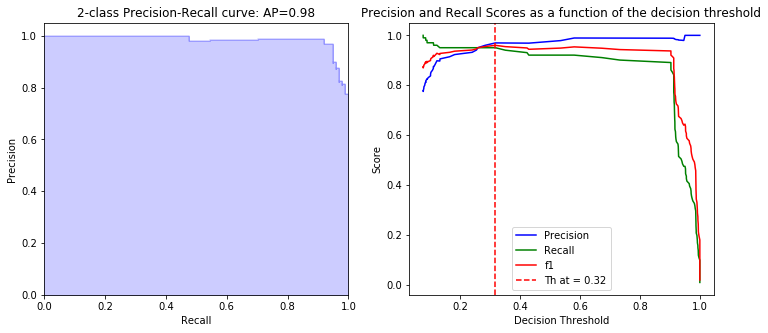

Best separation threshold: 0.31725360957511334


In [9]:
print('=========================================================================')
print("Size ensemble:", len(list_clusters), "Chosen resolutions:", resols_ref_th[res_chs])

svm_ind = np.array([]).reshape(0,Y_valid.shape[0])
for res_ch in res_chs:
    svm_ind = np.vstack((svm_ind, 
                         d_train["string{0}".format(res_ch)].predict_proba(X_valid_norm_th[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T
clf = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=16, probability=True), 
                   tuned_parameters_ens, iid=False, cv=cv_ens, scoring='roc_auc')

clf.fit(svm_ind, Y_valid)
print(clf.best_estimator_)

y_pred_probs = clf.predict_proba(svm_ind)[:,1]
__, opt_th = ax.plot_prc(Y_valid, y_pred_probs)

print('Best separation threshold: {}'.format(opt_th))

------------------------------------
ROC Curve Teste:


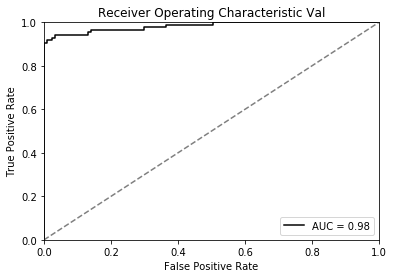

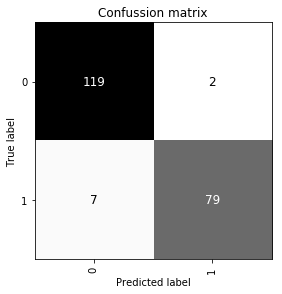

===== Final Report =====
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| AUC       | 0.98251  |
+-----------+----------+
| Accuracy  | 0.956522 |
+-----------+----------+
| Recall    | 0.918605 |
+-----------+----------+
| Precision | 0.975309 |
+-----------+----------+
| F1        | 0.946108 |
+-----------+----------+


In [10]:
svm_ind = np.array([]).reshape(0,Y_test.shape[0])
for res_ch in res_chs:
    svm_ind = np.vstack((svm_ind, 
                         d_train["string{0}".format(res_ch)].predict_proba(X_test_norm_th[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T

y_pred_probs = clf.predict_proba(svm_ind)[:,1]
AUC_cl = ax.plot_roc(Y_test, y_pred_probs)

y_pred = y_pred_probs > opt_th

mx_conf = confusion_matrix(Y_test, y_pred)
ax.plot_matrix(mx_conf, classes=np.unique(Y_test), fig_size=4, cmap=plt.cm.Greys, 
               title='Confussion matrix', opt_bar=False)

ind_err_rand = np.where(np.logical_xor(Y_test, y_pred))

accuracy, recall, precision, f1 = ax.report_metrics(mx_conf)

print('===== Final Report =====')
print(tabulate([['AUC', AUC_cl],
                ['Accuracy', accuracy],
                ['Recall', recall],
                ['Precision', precision],
                ['F1', f1],],
               ['Metric', 'Value'], tablefmt='grid'))

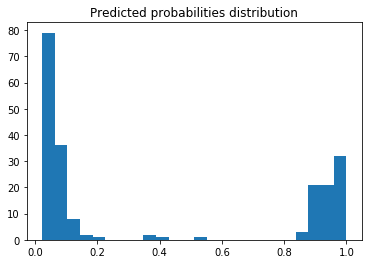

In [11]:
plt.hist(y_pred_probs,bins=24)
plt.title('Predicted probabilities distribution')
plt.show()

==================== Highest probabilities ====================


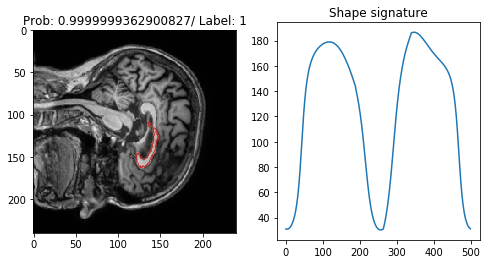

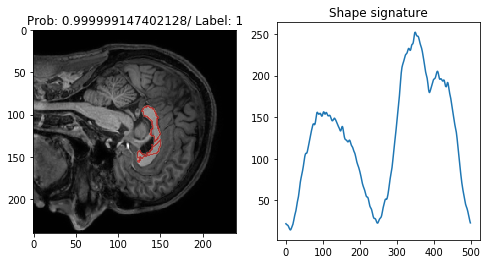

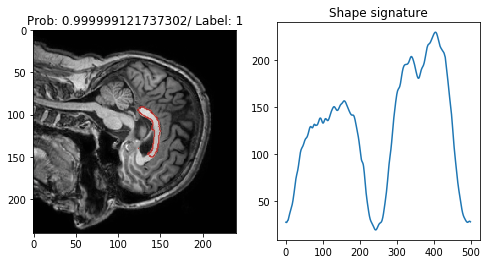

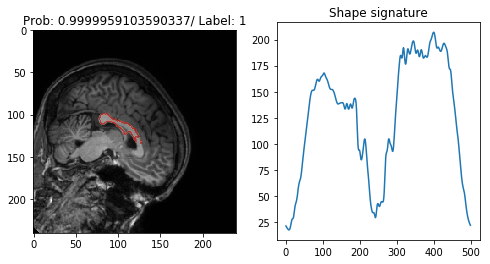

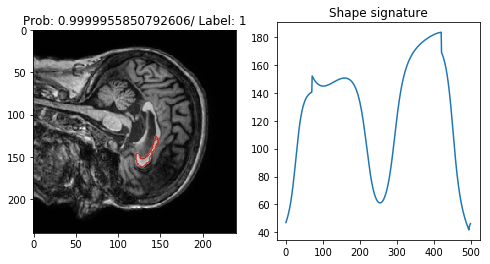

==================== Lowest probabilities ====================


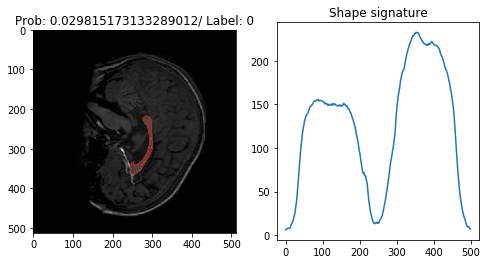

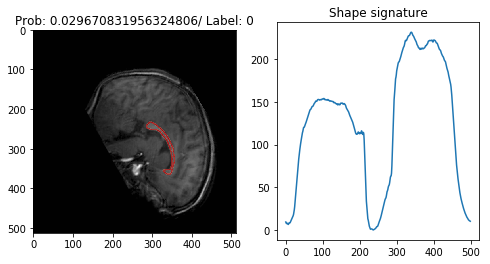

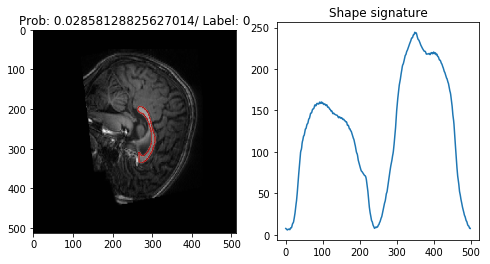

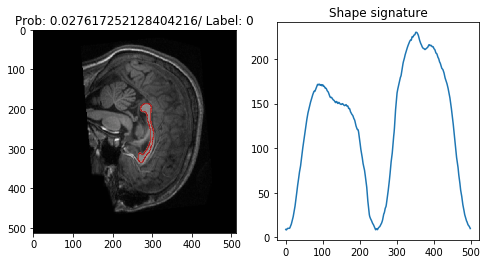

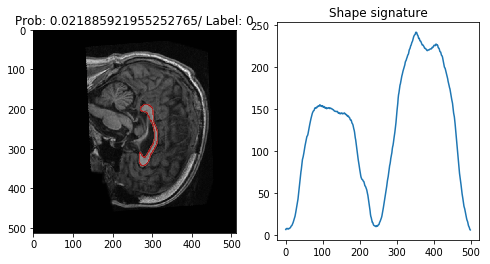

In [12]:
mycmap = ax.transparent_cmap(plt.cm.Reds)

dirs_test = np.array(dirs_all)[Y_filt][test_index]
prof_vec_test = prof_vec[Y_filt][test_index,reg_ex]

zipped_ord = sorted(zip(dirs_test,prof_vec_test,y_pred_probs,Y_test),key = lambda t: t[2],reverse=True)

print('==================== Highest probabilities ====================')

for best_subj in zipped_ord[:5]:
    ax.print_mask_img(best_subj, mycmap)

print('==================== Lowest probabilities ====================')
    
for best_subj in zipped_ord[-5:]:
    ax.print_mask_img(best_subj, mycmap)

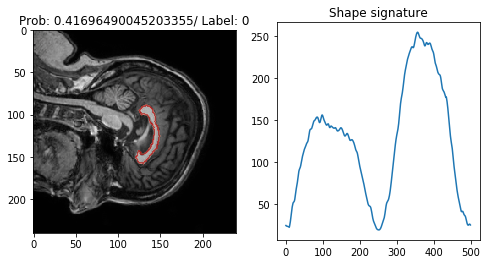

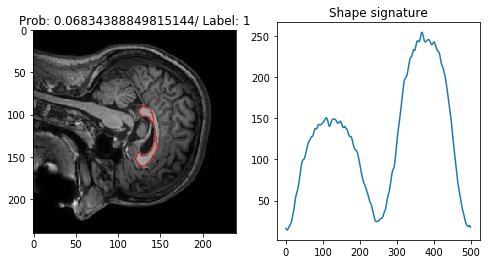

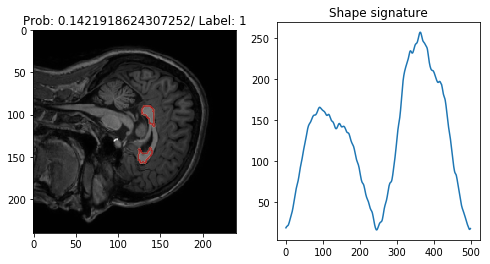

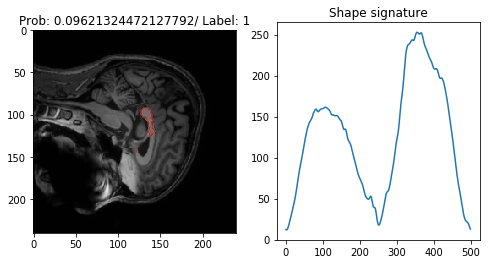

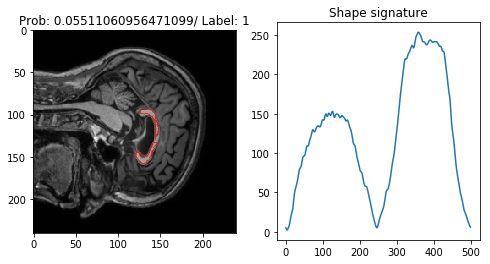

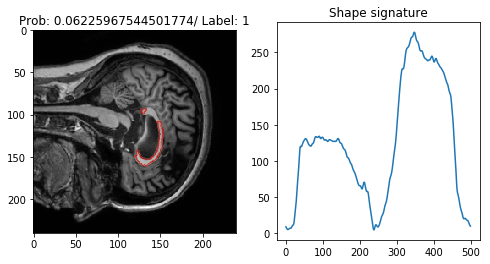

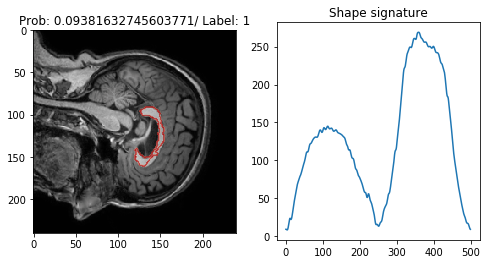

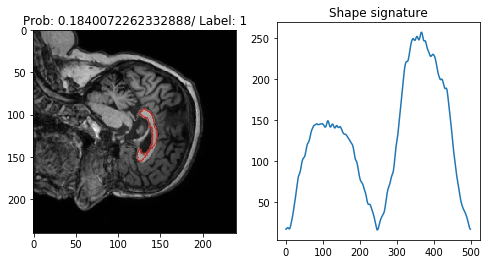

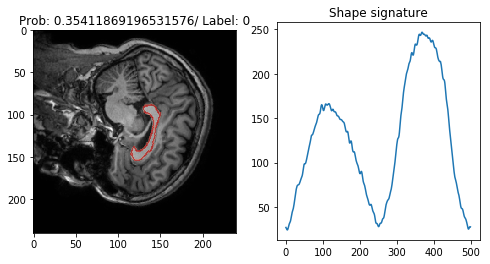

In [13]:
zipped = list(zip(dirs_test,prof_vec_test,y_pred_probs,Y_test))

for i_err in ind_err_rand[0]:
    ax.print_mask_img(zipped[i_err], mycmap)

## Analysis

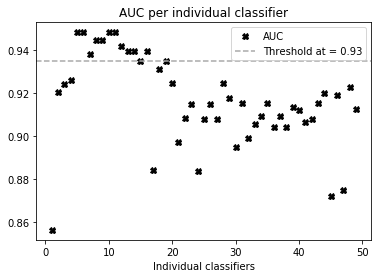

In [14]:
plt.figure()
plt.plot(np.arange(1,len(auc_vec)+1), auc_vec, 'X', color='black', label='AUC')
n_best_elements = len(list_clusters)
min_th = filt_acc[np.argsort(filt_acc)[-n_best_elements:][0]]
plt.axhline(y=min_th, label='Threshold at = {0:.2f}'.format(min_th), c='darkgray', linestyle='--')
plt.title('AUC per individual classifier')
plt.xlabel('Individual classifiers')
plt.legend(loc='best')
plt.show()

Size ensemble: 12 Chosen resolutions: [ 6 11 10  5  9  8 12 14 13 16  7 15]
SVC(C=50, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=16, shrinking=True,
  tol=0.001, verbose=False)


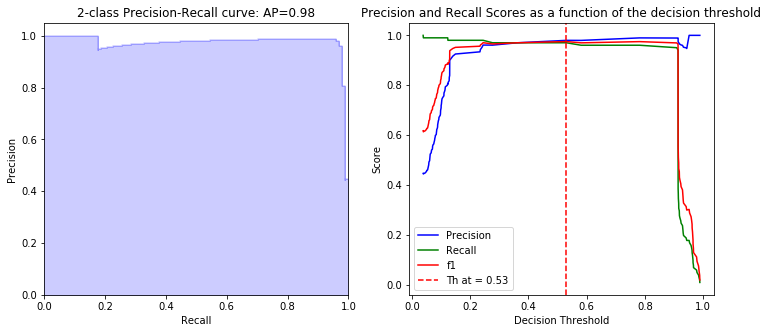

Best separation threshold: 0.5302757086495343


In [15]:
resols_min_th = np.argsort(auc_vec)[-n_best_elements:][::-1]
print('=========================================================================')
print("Size ensemble:", n_best_elements, "Chosen resolutions:", 
      resols_ref[resols_min_th])

tuned_parameters_ens = [{'kernel': ['rbf', 'linear'], 'C': [1, 10, 20, 50, 100],}]
cv_ens = StratifiedKFold(5, shuffle=True, random_state=88)#8

svm_ind = np.array([]).reshape(0,Y_valid.shape[0])

for res_ch in resols_min_th:
    svm_ind = np.vstack((svm_ind, d_train["string{0}".format(res_ch)].predict_proba(X_valid_norm[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T
clf = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', random_state=16, probability=True), 
                   tuned_parameters_ens, iid=False, cv=cv_ens, scoring='roc_auc')

clf.fit(svm_ind, Y_valid)
print(clf.best_estimator_)

y_pred_probs = clf.predict_proba(svm_ind)[:,1]
__, opt_th = ax.plot_prc(Y_valid, y_pred_probs)

print('Best separation threshold: {}'.format(opt_th))

------------------------------------
ROC Curve Teste:


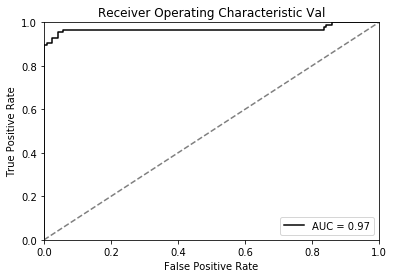

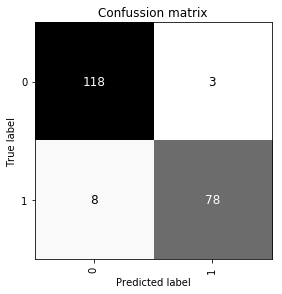

===== Final Report =====
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| AUC       | 0.968191 |
+-----------+----------+
| Accuracy  | 0.94686  |
+-----------+----------+
| Recall    | 0.906977 |
+-----------+----------+
| Precision | 0.962963 |
+-----------+----------+
| F1        | 0.934132 |
+-----------+----------+


In [16]:
svm_ind = np.array([]).reshape(0,Y_test.shape[0])
for res_ch in resols_min_th:
    svm_ind = np.vstack((svm_ind, d_train["string{0}".format(res_ch)].predict_proba(X_test_norm[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T

y_pred_probs = clf.predict_proba(svm_ind)[:,1]
AUC_best = ax.plot_roc(Y_test, y_pred_probs)

y_pred = y_pred_probs > opt_th

mx_conf = confusion_matrix(Y_test, y_pred)
ax.plot_matrix(mx_conf, classes=np.unique(Y_test), fig_size=4, cmap=plt.cm.Greys,
               title='Confussion matrix', opt_bar=False)

ind_err_rand = np.where(np.logical_xor(Y_test, y_pred))

accuracy, recall, precision, f1 = ax.report_metrics(mx_conf)

print('===== Final Report =====')
print(tabulate([['AUC', AUC_best],
                ['Accuracy', accuracy],
                ['Recall', recall],
                ['Precision', precision],
                ['F1', f1],],
               ['Metric', 'Value'], tablefmt='grid'))

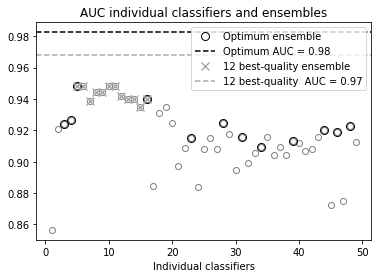

In [17]:
plt.figure()
plt.plot(np.arange(1,len(auc_vec)+1), auc_vec, 'o', color='gray', mfc='none')#, label='Classifiers')
plt.plot(resols_ref_th[res_chs], np.array(auc_vec)[resols_ref_th[res_chs]-1], 'o', color='black', mfc='none', 
         markersize=8, label='Optimum ensemble')
plt.axhline(y=AUC_cl, label='Optimum AUC = {0:.2f}'.format(AUC_cl), c='black', linestyle='--')
plt.plot(np.array(resols_min_th)+1, [auc_vec[i] for i in resols_min_th], 'x', color='darkgray', 
         markersize=8, mew=1.4, label='12 best-quality ensemble')
plt.axhline(y=AUC_best, label='12 best-quality  AUC = {0:.2f}'.format(AUC_best), c='darkgray', linestyle='--')
plt.title('AUC individual classifiers and ensembles')
plt.xlabel('Individual classifiers')
plt.legend(loc='best')
plt.show()